In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [86]:
data = pd.read_csv('train.csv')

Overview of the calculations going on throughout:
We take the X matrix which has all the values indicating greyscale (so betweeen 0 & 1 where 0 is fully white and 1 is fully black). We multiply it by a weight then add a bias to get our Z1 value (the 1 indicating its in the first layer excluding input layer). Note we randomise the values of weight and bias first time round and then use backpropagation to refine our choice of their values [ I THINK!]. This is fed into our activation function (which can vary, we use ReLu and softmax here) to get A1. These are the values in the first layer.
They are then multiplied by another weight and a bias is added to get Z2. Z2 isd fed into an activation function to get A2. In our case, as we only choose to have 1 hidden layer, A2 here is the output layer so it indicates which number we think is drawn in each image.

In [87]:
len(data)

42000

In [88]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
data = np.array(data)
m, n = data.shape # this sets m = number of inputs in training data and n = numbe of features in each input +1 (+1 because the shape also include the label i.e. which number the image is)
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T # next we split the training set so we have a subsection to do dev with. Don't want to do dev with training data bc when we come to training the model after it will have already seen these inputs.
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T  # note that transposing means that now each column represents an input
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [90]:
def init_params(z1_size, A_size): #note that here z1_size is the number of neurons in the first layer. A_size is the number of neurons in output layer (will be 10 here as there's 10 possible outputs)
    w1 = np.random.rand(z1_size, 784) - 0.5 # subtract 0.5 here because np.random.rand generates number between 0 & 1, we want values between -0.5 & 0.5
    b1 = np.random.rand(A_size, 1) - 0.5
    w2 = np.random.rand (z1_size, A_size) - 0.5
    b2 = np.random.rand(A_size, 1) - 0.5
    return w1, b1, w2, b2

In [91]:
def relu(Z):
    return np.maximum(0,Z) 

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) # creates array of zeros with dimensions = no. of inputs (aka "m" or Y.size here) by the numober of potential outputs (Y.max() + 1 = 9+1=10)
    one_hot_Y[np.arange(Y.size), Y] = 1 # np.arange (NOT arrange!) goes through the range of values between 0 and Y.size. "Y" takes the particualr value of Y for that inoput. Puts a 1 at this index
    one_hot_Y = one_hot_Y.T # this now means each COLUMN will be a n input example
    return one_hot_Y
    
def deriv_relu(Z):
    return Z > 0 #if False, this will be converted to 0 which is the slope of a horizontal line on graph. If True, this will be convered to 1 which is slope of linear line

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_relu(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1- alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2- alpha * db2
    return W1, b1, W2, b2

In [92]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params(10, 10)
    for i in range(iterations): # we now apply the functions created above iteratively
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0: # here we will check the accuracy every 10th iteration
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [93]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

Iteration:  0
[1 1 5 ... 2 5 5] [4 9 3 ... 1 6 3]
0.09480487804878049
Iteration:  10
[7 4 8 ... 6 2 8] [4 9 3 ... 1 6 3]
0.19702439024390245
Iteration:  20
[7 4 3 ... 6 2 8] [4 9 3 ... 1 6 3]
0.29321951219512193
Iteration:  30
[7 4 3 ... 6 2 8] [4 9 3 ... 1 6 3]
0.39078048780487806
Iteration:  40
[7 4 3 ... 6 6 8] [4 9 3 ... 1 6 3]
0.44858536585365855
Iteration:  50
[7 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.4960731707317073
Iteration:  60
[9 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.5325609756097561
Iteration:  70
[9 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.5640731707317073
Iteration:  80
[9 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.5880243902439024
Iteration:  90
[9 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.6098536585365854
Iteration:  100
[9 4 3 ... 1 6 8] [4 9 3 ... 1 6 3]
0.6299512195121951
Iteration:  110
[9 4 3 ... 1 6 3] [4 9 3 ... 1 6 3]
0.6484390243902439
Iteration:  120
[9 9 3 ... 1 6 3] [4 9 3 ... 1 6 3]
0.6645121951219513
Iteration:  130
[9 9 3 ... 1 6 3] [4 9 3 ... 1 6 3]
0.6793658536585366
Iteration:  

In [83]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [4]
Label:  4


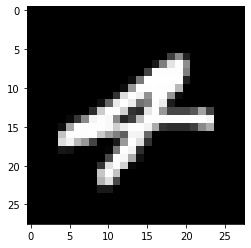

In [84]:
test_prediction(2, W1, b1, W2, b2)

In [94]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[5 7 0 5 5 4 7 7 9 2 1 6 9 2 5 4 7 1 0 1 6 7 6 3 3 6 9 6 2 6 1 8 9 0 2 7 9
 9 3 1 2 1 0 5 8 9 6 4 9 5 2 6 1 7 2 9 9 3 3 9 3 6 4 6 6 8 2 4 1 2 1 9 7 2
 9 2 6 0 1 0 9 2 1 5 4 4 6 0 3 4 4 4 9 3 1 4 8 9 4 3 7 0 7 7 3 4 6 3 3 7 8
 1 0 1 0 5 6 4 4 7 9 9 0 3 6 1 6 1 7 4 0 8 8 5 2 4 0 6 6 3 0 6 9 5 4 7 6 9
 1 3 8 9 1 1 9 6 6 2 9 0 4 2 0 7 1 4 3 2 7 8 9 2 4 0 6 7 0 6 5 6 6 0 0 3 6
 3 8 6 1 8 2 2 9 3 3 7 6 5 5 0 2 2 3 2 7 5 8 0 1 3 4 5 5 6 7 0 0 6 4 0 1 8
 9 8 2 4 1 9 4 6 1 9 6 9 4 2 6 7 0 7 9 4 9 0 0 2 1 1 8 1 7 6 7 5 4 4 2 8 9
 1 3 4 9 5 3 5 7 8 2 0 0 6 3 3 7 1 1 5 6 8 4 4 3 3 8 7 3 6 4 9 3 5 7 0 7 1
 1 9 4 4 2 7 3 9 8 6 3 9 0 1 0 5 7 5 6 8 2 2 2 7 9 4 8 5 4 1 7 4 4 6 4 3 6
 8 3 7 7 1 8 3 9 1 3 9 1 2 2 5 6 6 4 4 2 7 1 6 5 6 7 9 2 9 8 6 6 3 3 8 1 7
 4 2 9 4 9 9 4 2 6 4 3 2 9 9 0 9 1 6 9 7 7 4 9 7 5 7 7 5 8 1 1 5 3 4 8 0 2
 9 5 8 6 9 3 5 9 3 6 2 3 3 6 3 6 5 4 1 6 6 3 9 5 4 5 2 4 3 5 6 3 9 2 0 2 4
 1 1 8 4 6 0 2 0 0 1 0 6 6 9 1 7 9 6 9 7 5 1 1 9 3 8 1 9 0 3 3 7 7 0 3 3 2
 5 5 9 2 1 3 2 3 6 6 2 2 

0.845